In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
import os

In [3]:
data_folder = '/content/drive/MyDrive/data-analytics/uc3'

In [4]:
df_1 = pd.read_csv(os.path.join(data_folder, 'DSIB - Use Case 3 - Data.csv'), header=0, sep=',')
df_1.set_index('ID')
df_1.columns

Index(['ID', 'MENSPANTS_20200630', 'C_RECENCY_DAYS_20200531',
       'EMAIL_CLICK_20200531', 'TOT_TRANS_COUNT_20200531',
       'TRANS_COUNT_STORE_20200531', 'TRANS_COUNT_ONLINE_20200531',
       'PCNT_DISCOUNT_ITEMS_20200531', 'PCNT_MARKDOWN_ITEMS_20200531',
       'PCNT_DISC_MARK_ITEMS_20200531', 'PCNT_DISCOUNT_AMT_20200531',
       'PCNT_MARKDOWN_AMT_20200531', 'TOTAL_ITEMS_20200531',
       'TOTAL_SPEND_20200531', 'TOT_WOMENS_ITEMS_20200531',
       'TOT_WOMENS_SPEND_20200531', 'TOT_MENS_ITEMS_20200531',
       'TOT_MENS_SPEND_20200531', 'TOT_ACCESSORIES_ITEMS_20200531',
       'TOT_ACCESSORIES_SPEND_20200531', 'TOTAL_QUANTITY_20200531',
       'AVERAGE_AOV_20200531', 'NO_OF_WOMENS_PANTS_20200531',
       'NO_OF_WOMENS_TANKS_20200531', 'NO_OF_WOMENS_LS_TOPS_20200531',
       'NO_OF_WOMENS_SS_TOPS_20200531', 'NO_OF_WOMENS_CROPS_20200531',
       'NO_OF_WOMENS_HEADWEAR_20200531', 'NO_OF_WOMENS_SEASONAL_20200531',
       'NO_OF_MENS_HEADWEAR_20200531', 'NO_OF_MENS_SEASONAL_20200531',


In [11]:
selected_columns = ['ID', 'MENSPANTS_20200630', 'C_RECENCY_DAYS_20200531', 'EMAIL_CLICK_20200531',
                    'TOT_TRANS_COUNT_20200531', 'PCNT_DISCOUNT_ITEMS_20200531', 'PCNT_MARKDOWN_ITEMS_20200531',
                    'PCNT_DISCOUNT_AMT_20200531', 'PCNT_MARKDOWN_AMT_20200531', 'TOT_MENS_ITEMS_20200531',
                    'TOT_MENS_SPEND_20200531', 'AVERAGE_AOV_20200531', 'NO_OF_MENS_PANTS_20200531']
df_clean = df_1.loc[:, selected_columns]
# remove nan
df_clean['EMAIL_CLICK_20200531'] = df_clean['EMAIL_CLICK_20200531'].fillna(0)
print(df_clean.isnull().any().any())

False


Only consider customer who may interested in email campaign and menswear campaign:

In [12]:
# filter non-targeted customers
print('before filter: ', df_clean.shape)
df_clean = df_clean[(df_clean['EMAIL_CLICK_20200531'] > 0) & (df_clean['TOT_MENS_SPEND_20200531'] > 0) &
                    (df_clean['AVERAGE_AOV_20200531'] > 0)]
print('after filter: ', df_clean.shape)

before filter:  (81532, 13)
after filter:  (11030, 13)


In [7]:
df_clean.to_csv(os.path.join(data_folder, "clean-up-data.csv"), index=False)

In [13]:
# data frame prepared for analysis
selected_columns.remove('AVERAGE_AOV_20200531')
df_preprocess = df_clean.loc[:, selected_columns]
print('original shape of data to preprocess', df_preprocess.shape)

original shape of data to preprocess (11030, 12)


In [14]:
to_replace = ['<=5', '6-16', '17-33', '34-56', '57-86', '87-121', '122-145', '146-191', '192-270',
              '271-368', '369+']
replace_to = [1, 3, 6, 9, 15, 20, 23, 26, 29, 35, 40]
for i in range(len(to_replace)):
    df_preprocess['C_RECENCY_DAYS_20200531'] = \
        df_preprocess['C_RECENCY_DAYS_20200531'].replace(to_replace[i], replace_to[i])
df_preprocess['AVG_MENS_SPEND_PER_Item_20200531'] = df_preprocess['TOT_MENS_SPEND_20200531']/(df_preprocess['TOT_MENS_ITEMS_20200531']+1e-15)
selected_columns.remove('TOT_MENS_SPEND_20200531')
selected_columns.append('AVG_MENS_SPEND_PER_Item_20200531')
df_preprocess = df_preprocess.loc[:, selected_columns]
df_preprocess.to_csv(os.path.join(data_folder, "preprocessed-origin.csv"), index=False)
print('new shape', df_preprocess.shape)

new shape (11030, 12)


In [15]:
# min-max normalization
selected_columns.pop(0)
selected_columns.pop(0)
for col in selected_columns:
    df_preprocess[col] = MinMaxScaler().fit_transform(np.array(df_preprocess[col]).reshape(-1, 1))
df_preprocess.to_csv(os.path.join(data_folder, "preprocessed-new.csv"), index=False)

PCA

In [17]:
from sklearn.decomposition import PCA

df_1 = df_preprocess

features_headers = ['C_RECENCY_DAYS_20200531', 'EMAIL_CLICK_20200531', 'TOT_TRANS_COUNT_20200531',
                    'PCNT_DISCOUNT_ITEMS_20200531', 'PCNT_MARKDOWN_ITEMS_20200531', 'PCNT_DISCOUNT_AMT_20200531',
                    'PCNT_MARKDOWN_AMT_20200531', 'TOT_MENS_ITEMS_20200531', 'NO_OF_MENS_PANTS_20200531',
                    'AVG_MENS_SPEND_PER_Item_20200531']
features = df_1.loc[:, features_headers]

[0.36999811 0.34078166 0.20118822 0.02854456 0.01853491 0.01427288
 0.01043277 0.00665301 0.00570492 0.00388896]


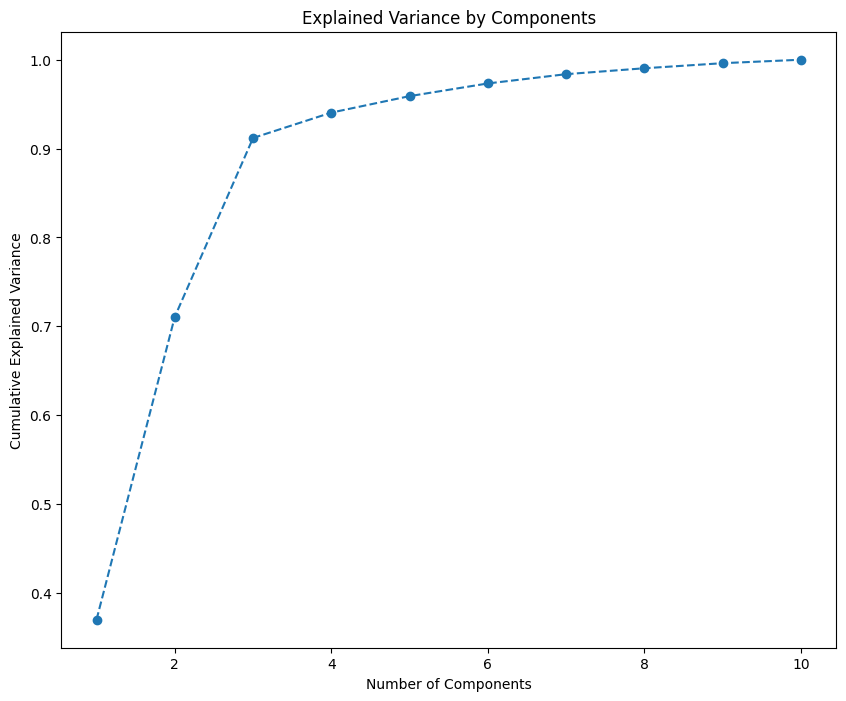

In [18]:
pca = PCA()
pca.fit(features)
print(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [19]:
pca = PCA(n_components=3)
pca.fit(features)
print(features_headers)
print(pca.components_)

['C_RECENCY_DAYS_20200531', 'EMAIL_CLICK_20200531', 'TOT_TRANS_COUNT_20200531', 'PCNT_DISCOUNT_ITEMS_20200531', 'PCNT_MARKDOWN_ITEMS_20200531', 'PCNT_DISCOUNT_AMT_20200531', 'PCNT_MARKDOWN_AMT_20200531', 'TOT_MENS_ITEMS_20200531', 'NO_OF_MENS_PANTS_20200531', 'AVG_MENS_SPEND_PER_Item_20200531']
[[-0.78917714  0.01019904  0.10830849  0.35258095 -0.41443103  0.17855125
  -0.18187571  0.04764504  0.04295807  0.01495054]
 [-0.56959253  0.00988176  0.04721145 -0.24599458  0.69252199 -0.10465088
   0.34534552  0.01487685  0.01284114 -0.05036061]
 [ 0.19573028 -0.00349454  0.04564244  0.77702711  0.36258679  0.38762898
   0.24075943  0.0304495   0.0188127  -0.12186666]]


Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import export_graphviz
import graphviz

In [21]:
df_1 = df_preprocess
df_1 = df_1.drop('ID', axis=1)

x = df_1.drop('MENSPANTS_20200630', axis=1)
print(x.head())
print(x.columns)
print(x.shape)
y = df_1['MENSPANTS_20200630']

    C_RECENCY_DAYS_20200531  EMAIL_CLICK_20200531  TOT_TRANS_COUNT_20200531  \
4                  0.000000              0.006462                  0.094017   
7                  1.000000              0.030695                  0.017094   
21                 0.205128              0.000000                  0.025641   
23                 0.051282              0.012924                  0.119658   
32                 1.000000              0.004847                  0.051282   

    PCNT_DISCOUNT_ITEMS_20200531  PCNT_MARKDOWN_ITEMS_20200531  \
4                            0.0                          0.00   
7                            0.0                          0.00   
21                           0.0                          0.00   
23                           0.0                          0.79   
32                           0.0                          0.10   

    PCNT_DISCOUNT_AMT_20200531  PCNT_MARKDOWN_AMT_20200531  \
4                          0.0                    0.000000   
7   

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy', accuracy)

total_pred = rf.predict(x)
print(total_pred[:15])
print(type(total_pred))
unique, counts = np.unique(total_pred, return_counts=True)
result = dict(zip(unique, counts))
print(result)

Accuracy 0.8349954669084315
[0 0 0 0 0 1 0 1 1 0 0 1 0 0 0]
<class 'numpy.ndarray'>
{0: 9359, 1: 1671}


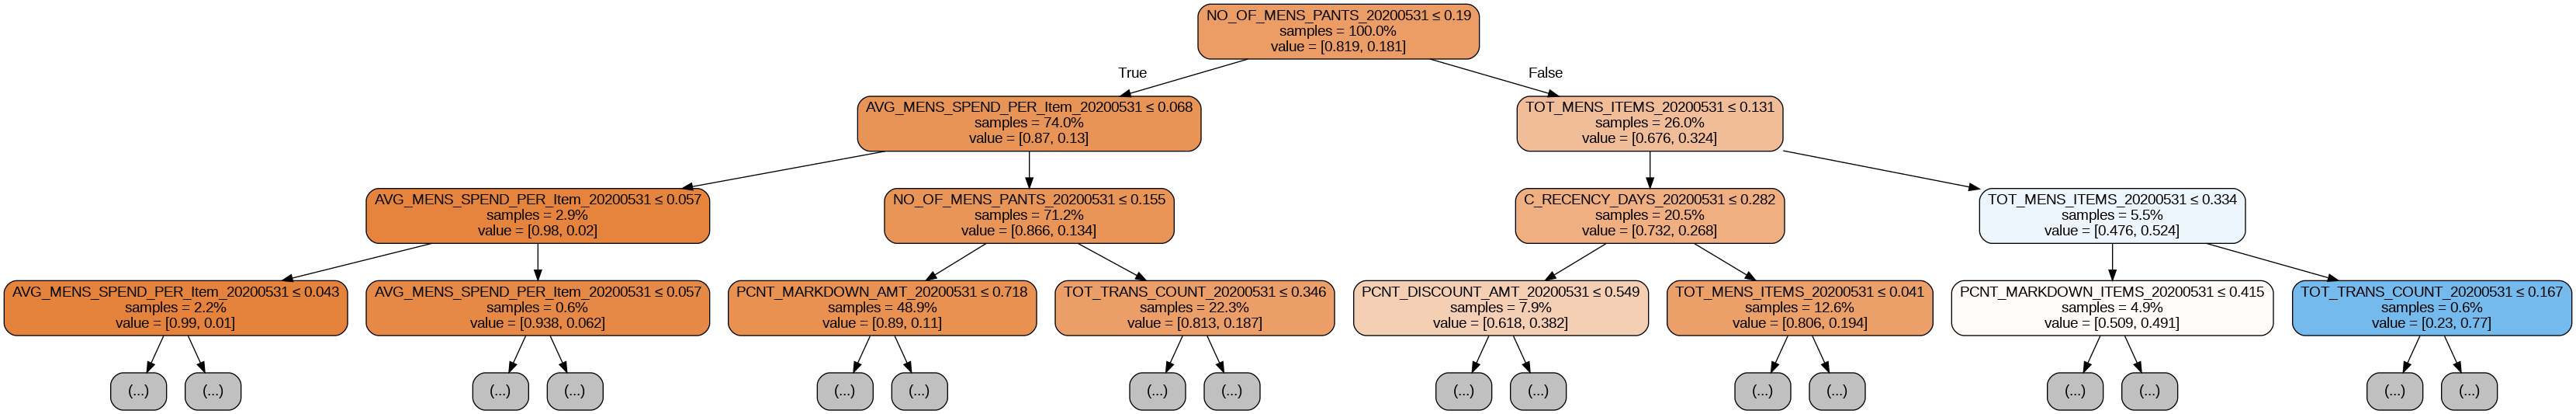

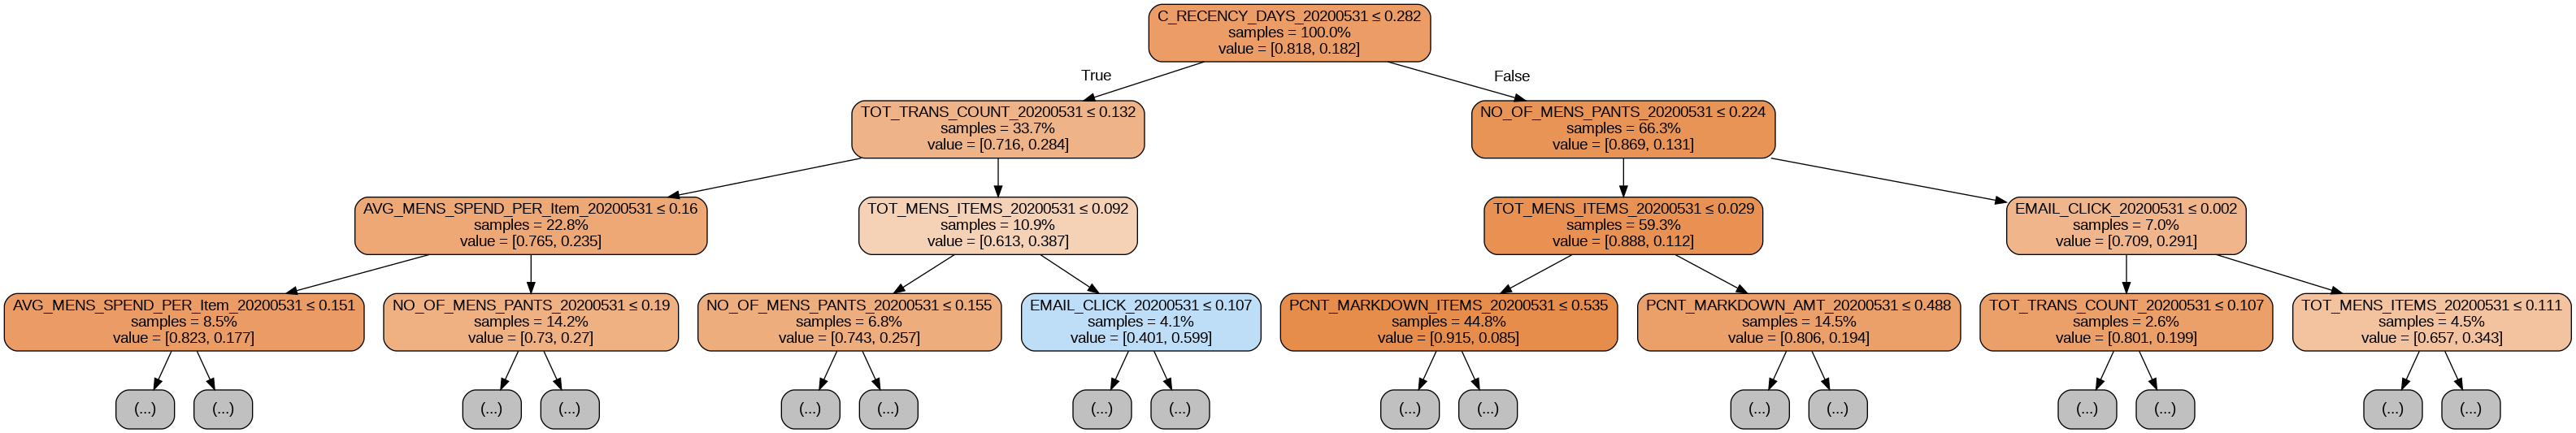

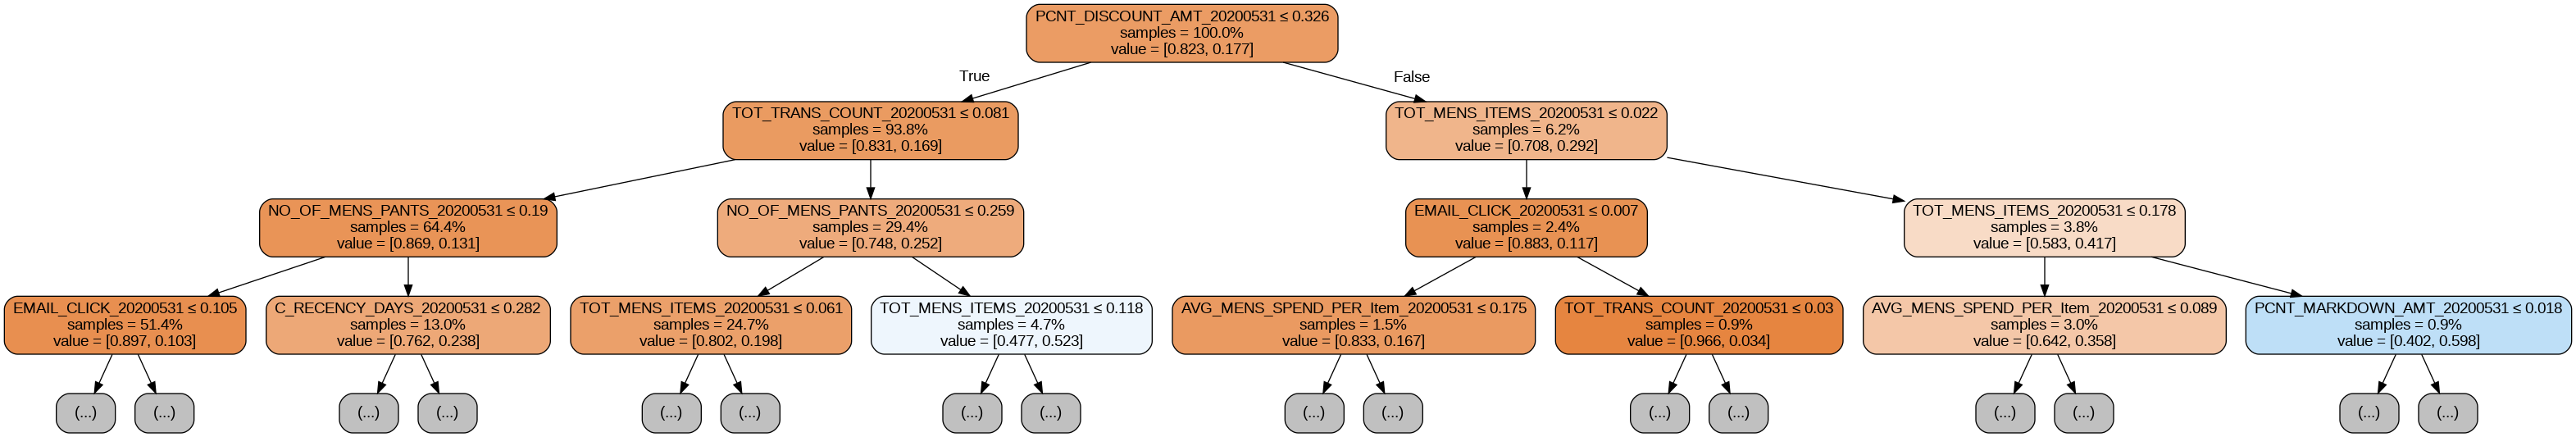

In [25]:
import IPython.display as display

for i in range(3):
    tree = rf.estimators_[i]
    # Export the decision tree to a Graphviz format
    dot_data = export_graphviz(tree, out_file=None,
                                feature_names=x.columns,
                                filled=True, rounded=True,
                                max_depth=3,
                                impurity=False,
                                special_characters=True,
                                proportion=True)
    # Visualize the decision tree using Graphviz
    graph = graphviz.Source(dot_data)
    # graph.view()
    file_name = 'tree ' + str(i)
    graph.render(file_name, format="png")
    display.display(display.Image("{0}.png".format(file_name)))

Feature Importance - weighted random forest

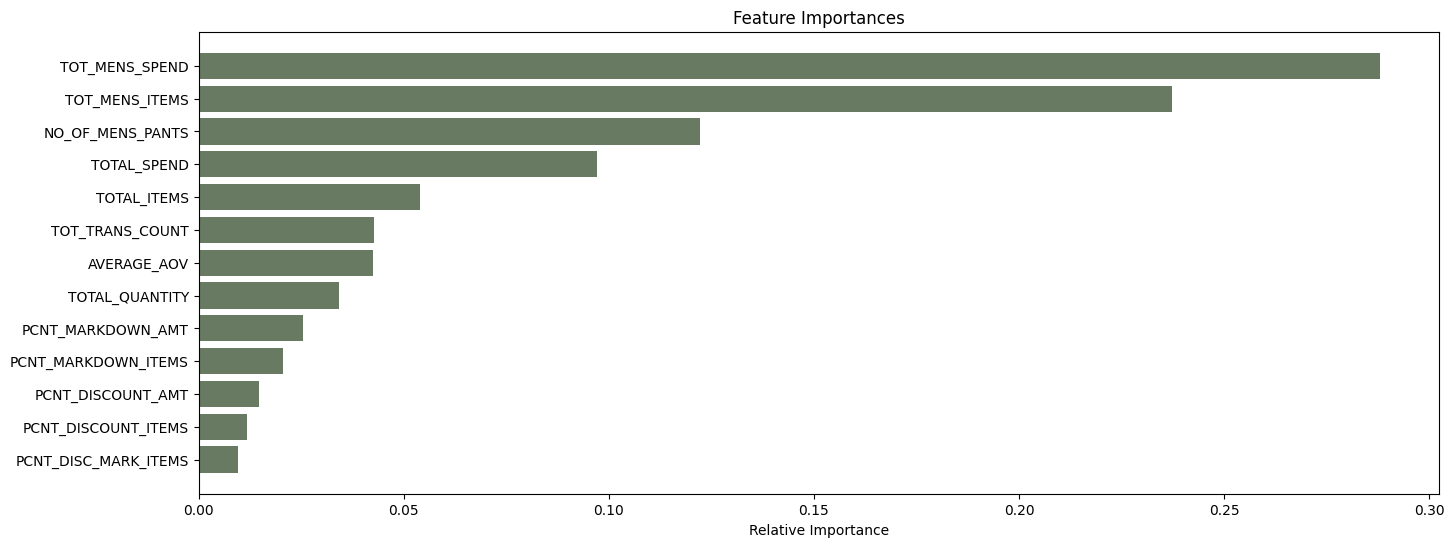

In [26]:
warnings.filterwarnings('ignore')
org_data = pd.read_csv(os.path.join(data_folder, 'DSIB - Use Case 3 - Data.csv'), header=0, sep=',')

select_cols = ['MENSPANTS_20200630', 'ID', 'C_RECENCY_DAYS_20200531', 'TOT_TRANS_COUNT_20200531',
                'TOTAL_ITEMS_20200531',
                'TOTAL_SPEND_20200531', 'TOT_MENS_ITEMS_20200531', 'TOT_MENS_SPEND_20200531',
                'NO_OF_MENS_PANTS_20200531',
                'TOTAL_QUANTITY_20200531', 'AVERAGE_AOV_20200531', 'PCNT_DISCOUNT_ITEMS_20200531',
                'PCNT_MARKDOWN_ITEMS_20200531',
                'PCNT_DISC_MARK_ITEMS_20200531', 'PCNT_DISCOUNT_AMT_20200531', 'PCNT_MARKDOWN_AMT_20200531']

X = org_data[select_cols[3:]]
y = org_data[select_cols[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weights = {0: 0.53, 1: 9.24}
clf = RandomForestClassifier(max_depth=10, class_weight=class_weights, random_state=16)
clf.fit(X_train, y_train)

importances = clf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.figure(figsize=(16, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#687A61', align='center')
plt.yticks(range(len(indices)), [features[i].removesuffix("_20200531") for i in indices])
plt.xlabel('Relative Importance')
plt.show()